# Introduction
This example notebook demonstrates the use of FiGLearn on synthetic data. In particular we generate a stochastic block model with three clusters. Then we generate signals on the created graph, using different kernels. From those signals, we then impute the graph, and compare it with the ground truth.

We start off by importing some stuff we'll need and setting our random seed.

In [1]:
import numpy as np
import torch
import sys
sys.path.append('../src/')

from matplotlib import pyplot as plt
from sklearn.metrics import f1_score

import generators as gen
from optimize import FiGLearn

%load_ext autoreload
%autoreload 2

In [2]:
seed=20

# SBM creation
We create stochastic block model with 45 nodes and 3 blocks of 15 nodes each. The probability of an edge within a block is 50%, the probability of an edge between blocks is 10%. The resulting adjacency matrix can be seen below.

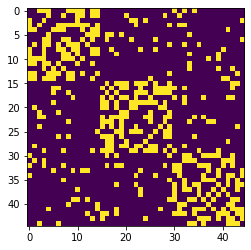

In [3]:
L = gen.generate_L_sbm(45, p_in=.5, n_blocks=3)
plt.imshow(L<0);

We write a helper functions to be able to easily plot results later.

In [4]:
def plot_results(L, ker, imp):
    A = imp.A
    plt.figure(figsize=(16,4))
    plt.subplot(141)
    plot_adj(L<0)
    plt.title('True Adjacency')
    
    plt.subplot(142)
    plot_adj(A>=.5)
    plt.title('Rounded Imputed Values')

    plt.subplot(143)
    plot_adj(A)
    plt.title('Imputed Values')

    plt.subplot(144)
    plot_kernel(L, ker, imp)

    print('F1 Score:', f1_score(np.array(L<0).flatten(), (A>.5).flatten()))
    
def plot_kernel(L, ker, imp):
    h = imp.h
    evals, _ = np.linalg.eig(L)
    x = torch.Tensor(np.linspace(0.01,evals.max()+1, num=100)).unsqueeze_(-1)
    plt.plot(x.numpy(), h(x).detach().numpy())
    plt.plot(evals, ker(torch.Tensor(evals)), 'ro')
    plt.legend(['Fitted', 'True'])
    plt.xlabel('Eigenvalue')
    plt.ylabel('Kernel');

def plot_adj(adj):
    plt.imshow(adj)
    plt.axis('off')

# Heat kernel
We start off by generating a heat kernel signal. To do so, we filter standard white noise with the heat kernel. The heat kernel has the form
$h(x) = e^{-kx}$ for some constant $k$ which is chosen to be $k=0.1$ in our case. This results in a smooth signal where connected nodes take similar values. We therefore expect the imputation to be rather easy.

In [5]:
ker = lambda x: gen.kernel_heat(x, alpha=.1)
samples = gen.gen_and_filter(L, 500, ker=ker, seed=42)

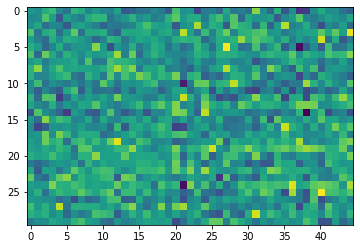

In [6]:
plt.imshow(samples[:30]);

We create a FiGLearn object and use it to fit our graph. It will simultaneously fit the graph adjacency matrix and the filter with which the observed signal can be obtained from standard white noise. 

In [7]:
heat = FiGLearn()
heat.fit_graph(samples, nit=5000)

[Epoch 5000/5000] loss: 0.011707

F1 Score: 0.9865470852017937


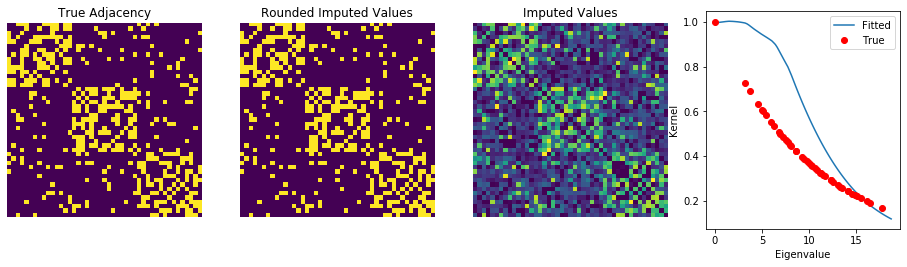

In [8]:
plot_results(L, ker, heat)
plt.savefig('../res/impute_heat.png')

We observe that the true adjacency matrix is very close to the rounded imputed adjacency matrix. However, the fitted kernel is considerably different from the true kernel, as can be seen on the plot on the very right. This is because during learning, the kernel is applied to the unrounded matrix. 
<br>
We can round the imputed values and fit a filter to the rounded adjacency matrix using the method `round`. By setting `copy` to true, we obtain a new object with the rounded adjacency. We specify the samples such that we can learn the filter of the rounded adjacency matrix.

In [9]:
heat_r = heat.round(samples, copy=True)

F1 Score: 0.9865470852017937


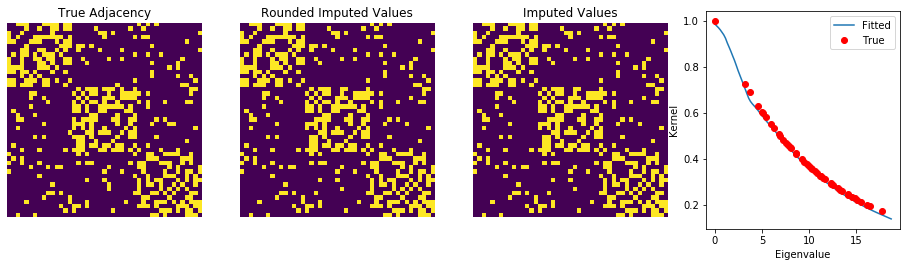

In [10]:
plot_results(L, ker, heat_r)

As you can see, the kernel applied to the rounded matrix now corresponds exactly to the true heat kernel.

# Normal kernel
We move on to a slighly more difficult task: Imputing signals that were generated using the normal kernel. The normal kernel takes the form:
\begin{align}
h_{\rm normal}(x) & = \begin{cases}
    \frac{1}{\sqrt{x}},& \text{if } x > 0\\
    0,              & \text{if } x=0
    \end{cases} \\
\end{align}

It poses a more difficult problem because the neural network will have to fit a continuous function (since neural nets are continuous functions by construction) to a non-continuous objective. The signals are still low-pass, meaning that similar nodes have similar signals.

In [11]:
ker = gen.kernel_normal
samples = gen.gen_and_filter(L, 500, ker=ker, seed=42)

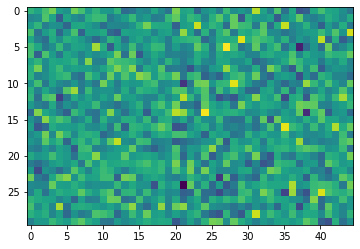

In [12]:
plt.imshow(samples[:30]);

In [13]:
norm = FiGLearn()
norm.fit_graph(samples, nit=5000)

[Epoch 5000/5000] loss: 0.010187

F1 Score: 0.8066825775656324


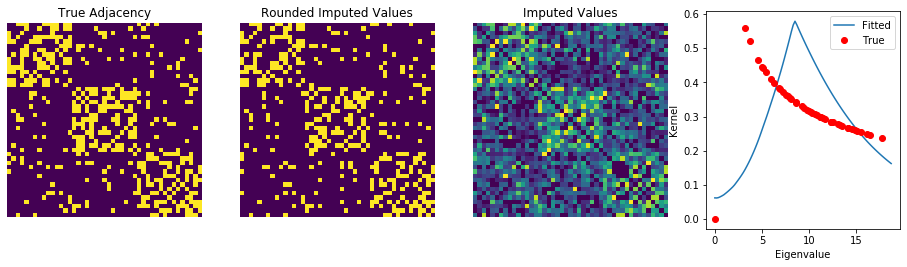

In [14]:
plot_results(L, ker, norm)
plt.savefig('../res/impute_norm.png')

Again you can see that the imputed adjacency matrix performs reasonably well. Nevertheless, the discontinuity in the filter resulted in a lower F1 score (0.81 as opposed to 0.99). Again, the imputed filter fits doesn't correspond to the ground truth because it is applied to the unrounded imputed values. We again do a rounding as before:

In [15]:
norm_r = norm.round(samples, copy=True)

F1 Score: 0.8066825775656324


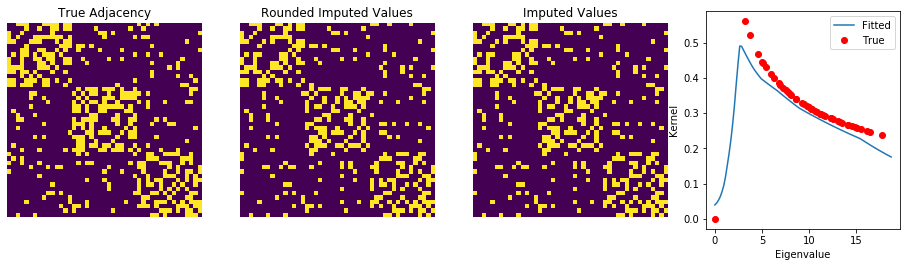

In [16]:
plot_results(L, ker, norm_r)

Now we see that the imputed filter matches the true kernel quite well at the positions of the matrix eigenvalues. 
<br>
However, note that during our learning process, the neural network just sees the kernel values at the positions where the matrix has eigenvalues. It cannot learn what is going on between them and thus assumes that the target function is somewhat smooth, when in fact it is not. This is not a problem when we use the filter on our graph. However, the filter will generalize poorly to other graphs, whose Laplacians may have eigenvalues at positions where the filter is poorly approximated.

# Highpass Filter

Now as a last example, we consider a high-pass filter. This task is considerably harder, because nodes that are connected through an edge now tend to take different values. In particular we use the filter 
\begin{align}
h_{\rm high-pass}(x) &= \frac{0.1x}{1+0.1x}
\end{align}

In [17]:
ker = gen.kernel_highpass
samples = gen.gen_and_filter(L, 500, ker=ker, seed=42)

Because the task is harder, we optimize the Laplacian with gradient descent instead of the Adam optimizer. It tends to take more time until convergence, but converges to local minima that give a better final result. To compensate for the slower convergence, we can increase the learning rate for the Laplacian by two orders of magnitude. 

In [18]:
high = FiGLearn()
high.fit_graph(samples, nit=5000, lr_L=1, optim_L='gd')

[Epoch 5000/5000] loss: 0.083608

F1 Score: 0.7542213883677298


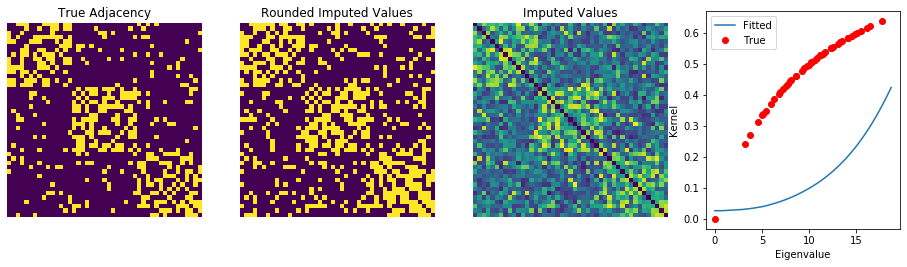

In [19]:
plot_results(L, ker, high)
plt.savefig('../res/impute_hp.png')

We observe again that the quality of the imputed graph is high, considering that the task is hard. We do the same rounding procedure as before:

In [20]:
high_r = high.round(samples, copy=True)

F1 Score: 0.7542213883677298


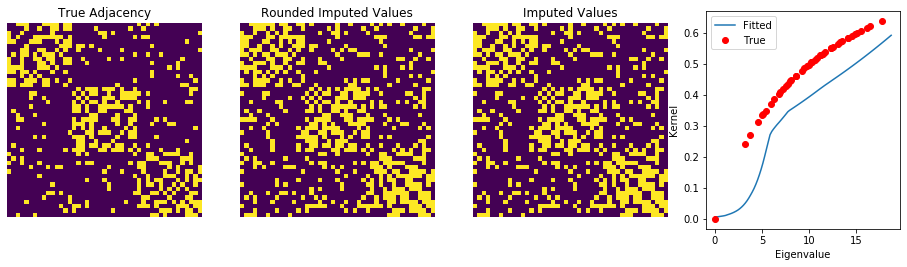

In [21]:
plot_results(L, ker, high_r)

We see that the imputed filter behaves similarly to the true kernel. However it is not perfect, which is due to the fact that we don't perfectly recover the graph.

# Learn only the Filter
This example demonstrates the case where the graph structure is known and we only want to learn the filter that generates the graph. We again use our stochastic block model and a high-pass signal.

In [22]:
ker = gen.kernel_highpass
samples = gen.gen_and_filter(L, 500, ker=ker, seed=42)

When initiating the graph object, we give either the Laplacian or the adjacency matrix of our graph as an input. The constructor automatically infers which one was given based on whether or not negative values were provided. We then call the method fit_filter of the object and provide our samples.

In [23]:
filterlearn = FiGLearn(L)
filterlearn.fit_filter(samples)

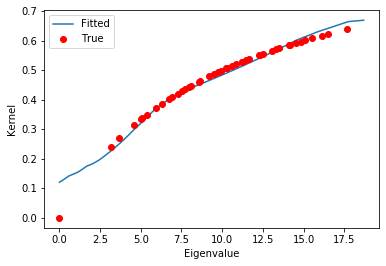

In [24]:
plot_kernel(L, ker, filterlearn)

We see in the results that the method did a good job in learning the filter from the data.

# Learn only the Graph
We can also learn only the graph, by specifying the filter in advance. In the example presented here, we assume that we have some examples where both graphs and signals are known, and others for which we only have the signal. We can learn the filter on the example where we have a graph and a signal, and use that filter for learning a new graph.
<br>
To demonstrate this, we generate a new stochastic block model, this time with only two blocks, on which we again create a signal with a high-pass filter. We will use the filter learned above for learning the graph.

In [25]:
new_L = gen.generate_L_sbm(nnodes=45, p_in=.5, n_blocks=2)
new_samples = gen.gen_and_filter(new_L, 500, ker=ker, seed=42)

We provide the filter h in the constructor of the FiGLearn object. Moreover, when fitting the graph we set the option `learn_h` to false.

In [26]:
graphlearn = FiGLearn(h=filterlearn.h)
graphlearn.fit_graph(new_samples, nit=1000, learn_h=False)
                     

[Epoch 1000/1000] loss: 0.177805

F1 Score: 0.7410207939508507


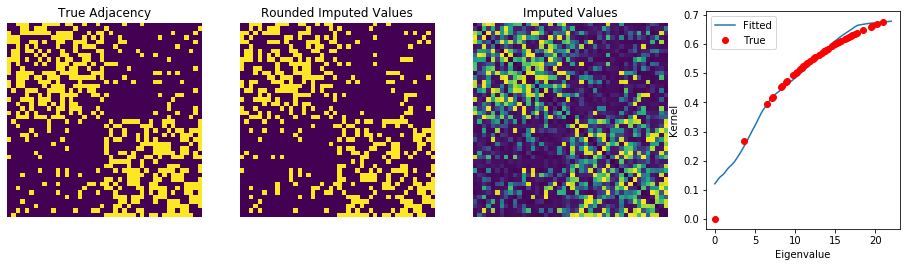

In [27]:
plot_results(new_L, ker, graphlearn)

As you can see, if the filter information is known already we can recover the graph much faster. Moreover, since we no longer jointly optimize the filter and the Laplacian we don't need to be as careful and can use the faster Adam optimizer.

# Including Domain Knowledge about Filter
In the case where we have some information about the filter, such as it having a specific form, we can also create a custom torch model which will be used during filter learning. We consider once more the case of a high-pass filter of the form 
\begin{align}
h_{\rm high-pass}(x) &= \frac{ax}{1+ax}
\end{align}
where the constant $a$ is unknown. We create a high-pass filter module as follows:

In [28]:
class HighPass(torch.nn.Module):
    
    
    def __init__(self):
        super().__init__()
        self.a = torch.nn.Parameter(torch.Tensor([1]))   
        
    def forward(self, x, tol=1e-3):
        return self.a*x/(1+self.a*x)


We give the HighPass object to the constructor and jointly fit the graph and filter as usual. 

In [29]:
hp_filter = HighPass()
customlearn = FiGLearn(h=hp_filter)
customlearn.fit_graph(samples, nit=1000)


[Epoch 1000/1000] loss: 0.1908913

F1 Score: 0.8019323671497584


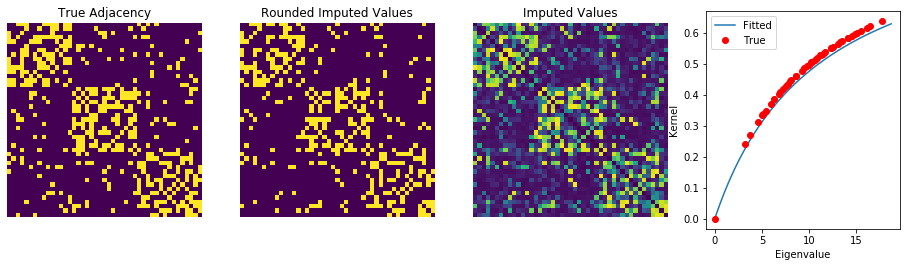

In [30]:
plot_results(L, ker, customlearn)

The results show that including the filter improves the F1-score. We further see that the parameter a that was fitted is with a value of 0.091 close to 0.1, the true value.

In [31]:
hp_filter.a.item()

0.09129443019628525